### RAG(Retrieval Augmented Generation) practice 
- Retrieval -Find relevant information given a query
- Augmentation -Take the relevant information from retrieval and augment our input(prompt) to an LLM with that relevant information.
- Generation - Take the first two steps and pass them to an LLM for generative outputs.

### Why RAG?
- The main goal of RAG is to improve the generation outputs of LLMs. 
- Most of what I practiced were based on fine-tuning. It can provide up-to-date information to the model with less efforts.
### Steps
- Import PDF
- Process text for embedding
- Embed text chunks with embedding model.
- Save embeddings to file for later
### Practiced with 
- Daniel Bourke- Local Retrieval Generation(RAG) from Scratch(step by step tutorial)
- https://www.youtube.com/watch?v=qN_2fnOPY-M&t=513s
### The project is about
- Using RAG to augment pdf document information to a local LLM model.
- Getting a LLM model that is knowledgable on up-to-date Virginia Tech ECE Graduate students policy.

### Import PDF Document

In [1]:
import os 
import requests

# Get PDF docu path
pdf_path = "ECE Graduate Policy Manual AY2023-2024.pdf"

# download 
if not os.path.exists(pdf_path):
    print(f"[INFO] File doesn't exist, downloading...")

    # Enter the URL of the PDF 
    # Did not put URL of VT ECE graduate policy link on purpose. Let's edit this if I need to actually download a pdf file from a site later on.
    url = "example_url" 

    filename = pdf_path 

    response = requests.get(url)

    if response.status_code == 200: 
        with open(filename,"wb") as file:
            file.write(response.content)
        print(f"[INFO] The file has been downloaded and saved as {filename}")
    else:
        print(f"[INFO] failed to download the file. status code: {response.status_code}")
else:
    print(f"File {pdf_path} exists.")


File ECE Graduate Policy Manual AY2023-2024.pdf exists.


In [2]:
# Use PyMuPDF to open a pdf instead of pypdf
import fitz 
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip()

    # potentially more text formatting can be put in here. 
    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        # page_number - 4 was done to distinguish Table of Contents from main contents
        pages_and_texts.append({"page_number": page_number-4,
                                "page_char_count":len(text),
                                "page_word_count":len(text.split(" ")),
                                "page_sentence_count_raw":len(text.split(". ")),
                                "page_token_count":len(text)/4, # 1 token = ~4 characters
                                "text":text})
    return pages_and_texts
pages_and_texts = open_and_read_pdf(pdf_path = pdf_path)
pages_and_texts[7:8]
        

0it [00:00, ?it/s]

[{'page_number': 3,
  'page_char_count': 3688,
  'page_word_count': 596,
  'page_sentence_count_raw': 19,
  'page_token_count': 922.0,
  'text': "7  1.2 Virginia Tech Graduate Honor Code    The Graduate Honor Code establishes a standard of academic integrity. As such, this code  demands a firm adherence to a set of values. In particular, the code is founded on the concept  of honesty with respect to the intellectual efforts of oneself and others. Compliance with the  Graduate Honor Code requires that all graduate students exercise honesty and ethical behavior  in all their academic pursuits at Virginia Tech, whether these undertakings pertain to study,  course work, research, extension, or teaching.  It is recognized that graduate students have very diverse cultural backgrounds. In light of this,  the term ethical behavior is defined as conforming to accepted professional standards of  conduct, such as codes of ethics used by professional societies in the United States to regulate  the

In [3]:
import random

random.sample(pages_and_texts, k=1)

[{'page_number': 25,
  'page_char_count': 3091,
  'page_word_count': 523,
  'page_sentence_count_raw': 41,
  'page_token_count': 772.75,
  'text': '29   4 Master’s Degree Program Requirements  The ECE Department offer a Master of Science (M.S.) degrees in both Electrical Engineering  (EE) and Computer Engineering (CPE) with both Thesis and Non-thesis options. In addition, the  department offers Master of Engineering (M.Eng.) degrees in both EE and CPE.   The M.S. Thesis degree and an M.S. Non-thesis degree are research-based degrees based on  graduate coursework. The M.S. Thesis student participates in independent research done under  the direct supervision of an ECE faculty member culminating in an M.S. thesis. The M.S. Non- thesis degree is a coursework only degree.  The M.Eng. degree is a professionally-oriented degree that offers graduate students a strong  academic foundation in core ECE technological areas with a culminating, project-based learning  experience. The M.Eng. degree 

In [4]:
import pandas as pd
df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-4,67,11,1,16.75,ECE Graduate Student Policy Manual For the 20...
1,-3,5340,389,50,1335.00,1 Table of Contents 1 General Information ....
2,-2,6006,467,60,1501.50,2 2.9.10 Exchange (Non-Degree) Status .........
3,-1,5352,389,63,1338.00,3 4.9 Coursework Justification ................
4,0,664,47,6,166.00,4 7 Appendix ..................................


In [5]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,54.00,54.00,54.00,54.00,54.00
mean,22.50,2761.83,445.83,25.11,690.46
std,15.73,1095.41,151.94,15.45,273.85
min,-4.00,67.00,11.00,1.00,16.75
25%,9.25,2412.25,425.00,13.25,603.06
50%,22.50,2822.50,478.00,24.00,705.62
75%,35.75,3230.00,531.75,34.50,807.50
max,49.00,6006.00,638.00,63.00,1501.50


### Further text processing(splitting pages into sentences)


In [6]:
from spacy.lang.en import English

nlp = English()
nlp.add_pipe('sentencizer')

doc= nlp("This is a sentence. This is another sentence. I like penguins")
assert len(list(doc.sents)) == 3

# print split sentences

list(doc.sents)

[This is a sentence., This is another sentence., I like penguins]

In [7]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # All sentences are strings(the default type is a spaCy data type) 
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    #count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/54 [00:00<?, ?it/s]

In [8]:
random.sample(pages_and_texts, k=1)

[{'page_number': 38,
  'page_char_count': 2901,
  'page_word_count': 531,
  'page_sentence_count_raw': 43,
  'page_token_count': 725.25,
  'text': "42 foreign language requirement for Ph.D. students. Additional requirements for coursework listed  on the Ph.D. plan of study include the following.  •  Ph.D. course work consists of 27 credit hours: a minimum of 24 course credit hours at the  5000-level or above.  •  2 credit hours of Seminar, ECE 5944 (These courses can be transferred from a Virginia  Tech M.S. degree in Computer Engineering or Electrical Engineering).  •  1 credit hour of Graduate Student Success in Multicultural Environments, ENGE  5304. (This course can be transferred from a Virginia Tech M.S. degree in Computer  Engineering or Electrical Engineering).  •  A maximum of 3 credit hours of 4000-level courses may be listed on the Ph.D. Plan of  Study. 3000-level or lower courses are not permitted.  •  The Virginia Tech Residency Requirement requires course work at the Ph.D

In [9]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,54.00,54.00,54.00,54.00,54.00,54.00
mean,22.50,2761.83,445.83,25.11,690.46,17.00
std,15.73,1095.41,151.94,15.45,273.85,9.52
min,-4.00,67.00,11.00,1.00,16.75,1.00
25%,9.25,2412.25,425.00,13.25,603.06,11.25
50%,22.50,2822.50,478.00,24.00,705.62,17.50
75%,35.75,3230.00,531.75,34.50,807.50,23.00
max,49.00,6006.00,638.00,63.00,1501.50,40.00


### chunking sentences 
text splitting(chunking)
- This is done to fit into embedding model context window(model I'll use has 384 tokens as a limit)

In [10]:
# could use langchain instead, but stick to python for now. 
num_sentence_chunk_size=10

def split_list(input_list: list[str], 
               slice_size: int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(25))
split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [11]:
# loop through pages and texts and split sentences into chunks 
for item in tqdm(pages_and_texts): 
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size = num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/54 [00:00<?, ?it/s]

In [12]:
random.sample(pages_and_texts, k=1)

[{'page_number': 14,
  'page_char_count': 3438,
  'page_word_count': 612,
  'page_sentence_count_raw': 28,
  'page_token_count': 859.5,
  'text': '18 Philosophy (PhD) in either the Electrical Engineering (EE) or Computer Engineering (CPE)  programs. The advantage of the program is that it allows enrolled students to double-count up  to 12 course credit hours (with the restrictions listed below) toward both degrees.  Virginia Tech undergraduate students who have a minimum GPA of 3.3 or better on all  undergraduate work, may apply for admission to the Accelerated ECE UGG Degree program. A  student may enter the program within the 12-month time period prior to the expected completion  date of their BS degree. To receive graduate credit, acceptance into the Accelerated UGG  Degree program is required prior to the semester in which enrolled in the courses selected for  double-counting.  Once accepted to the program, and during the last two semesters of their  undergraduate program, students

In [13]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,54.00,54.00,54.00,54.00,54.00,54.00,54.00
mean,22.50,2761.83,445.83,25.11,690.46,17.00,2.24
std,15.73,1095.41,151.94,15.45,273.85,9.52,0.91
min,-4.00,67.00,11.00,1.00,16.75,1.00,1.00
25%,9.25,2412.25,425.00,13.25,603.06,11.25,2.00
50%,22.50,2822.50,478.00,24.00,705.62,17.50,2.00
75%,35.75,3230.00,531.75,34.50,807.50,23.00,3.00
max,49.00,6006.00,638.00,63.00,1501.50,40.00,4.00


### splitting each chunk into its own item
- Embed each chunk of sentences into its own numerical representation.(granularity)

In [14]:
import re

# split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # join the sentences together into a paragraph like structure
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'.\1', joined_sentence_chunk)

        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token ~ 4 chars

        pages_and_chunks.append(chunk_dict)
len(pages_and_chunks)
        


  0%|          | 0/54 [00:00<?, ?it/s]

121

In [15]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 5,
  'sentence_chunk': 'Detailed information on changing from any ECE Master’s degree to another ECE graduate degree is given here. 1.9 Petitions to the ECE Graduate Committee  This ECE Graduate Policy Manual includes the policies and procedures for ECE graduate degree programs.In exceptional cases, a student may have legitimate reasons for deviating from these general requirements.In such cases, the student may submit a petition to the ECE Graduate Committee to request special consideration. 1.10 Minimum Registration for Students on Assistantships All graduate students who are supported by a teaching or research assistantship must be enrolled for some combination of coursework, research, or independent study totaling at least 12 credit hours during the semester they are funded. 1.11 English Proficiency for Teaching Assistants  The duties of graduate teaching assistants in ECE often include direct instructional contact. Therefore, international students whose native la

In [16]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)
df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
0,-4,ECE Graduate Student Policy Manual For the 202...,66,10,16.50
1,-3,1 Table of Contents 1 General Information .......,5256,305,1314.00
2,-2,2 2.9.10 Exchange (Non-Degree) Status ...........,5906,367,1476.50
3,-1,3 4.9 Coursework Justification ..................,5271,308,1317.75
4,0,4 7 Appendix ....................................,654,37,163.50


In [17]:
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(3).iterrows():
    print(f'chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')
    

chunk token count: 2.75 | Text: There is no
chunk token count: 16.5 | Text: ECE Graduate Student Policy Manual For the 2023-2024 Academic Year
chunk token count: 0.75 | Text: The


In [18]:
# filter out dataframe for rows under 30 tokens 
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[7:10]

[{'page_number': 2,
  'sentence_chunk': 'Thus, the information in this Manual supplements, and in many cases supersedes, the information given in the Graduate Catalog.This Manual includes the department rules and regulations that apply to ECE graduate students and assistants together with many of the most commonly encountered Graduate School regulations.Students must consult the Graduate Catalog and this manual when planning or revising their plans of study.',
  'chunk_char_count': 421,
  'chunk_word_count': 61,
  'chunk_token_count': 105.25},
 {'page_number': 3,
  'sentence_chunk': '7 1.2 Virginia Tech Graduate Honor Code  The Graduate Honor Code establishes a standard of academic integrity.As such, this code demands a firm adherence to a set of values.In particular, the code is founded on the concept of honesty with respect to the intellectual efforts of oneself and others.Compliance with the Graduate Honor Code requires that all graduate students exercise honesty and ethical behavio

### embedding text chunks
- text -> number .. learned representations
- Embedding model: all-mpnet-base-v2
- Transformer: Sentence-Transformer

In [19]:
from sentence_transformers import SentenceTransformer
#choose other model if needed
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                     device="cpu")

sentences = ["One winner, 42 losers. I eat losers for breakfast.",
             "I am Moana of Motunui. You will board my boat, sail across the sea, and restore the heart of Te Fiti.",
             "Your mind is like this water, my friend. When it is agitated, it becomes difficult to see. But if you allow it to settle, the answer becomes clear"]

embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences,embeddings))

for sentence, embedding in embeddings_dict.items():
    print(f'Sentence: {sentence}')
    print(f"Embedding: {embedding}")
    print("")

Sentence: One winner, 42 losers. I eat losers for breakfast.
Embedding: [ 1.15046920e-02  1.13322273e-01  1.85373034e-02  6.38279617e-02
 -3.11114974e-02 -2.39148107e-03 -7.74082169e-02  7.86641333e-03
  8.84707365e-03  1.39631983e-02  5.92519678e-02 -3.69009115e-02
 -1.52639113e-02 -1.45488102e-02  4.17278074e-02 -2.85042431e-02
 -3.15775648e-02 -2.98556685e-02 -4.84288717e-03 -1.44464076e-02
 -7.40296021e-02  1.76092349e-02  2.75924206e-02  2.90649780e-03
 -1.54584108e-04  4.33346368e-02  3.12447194e-02  2.67929360e-02
 -1.64484996e-02 -7.76191652e-02  1.54406307e-02  1.30614564e-02
 -3.93566415e-02 -7.51571031e-03  1.92927700e-06 -3.57409604e-02
 -1.43471798e-02  3.73234488e-02 -3.78098786e-02  1.95336640e-02
 -5.33196069e-02  4.20520715e-02 -2.45027579e-02  1.37061253e-02
 -2.96841860e-02  1.34968217e-02 -2.76567489e-02  4.77359258e-02
  1.62776429e-02  1.54969830e-03  1.26459068e-02 -3.21757048e-02
  1.46062532e-02 -2.52563637e-02 -1.62457358e-02 -1.10004451e-02
  3.45287174e-02 -

In [20]:
embeddings[0].shape

(768,)

In [21]:
embedding = embedding_model.encode("John Donne was the best poet in history")
embedding

array([ 7.97574501e-03,  8.51745158e-02,  1.43370498e-02,  3.23541239e-02,
       -1.08743710e-02,  1.46376691e-03,  1.62877105e-02, -6.10514032e-03,
       -6.42639920e-02, -1.35684870e-02, -8.98757204e-03,  2.22515035e-02,
       -1.72912106e-02, -4.42087613e-02, -3.35173234e-02, -5.40120713e-02,
       -1.87907871e-02,  4.45181876e-02,  2.61868145e-02,  2.73707900e-02,
       -5.16821817e-02,  1.58530343e-02,  4.20359056e-03, -5.53753600e-02,
        5.07049598e-02, -3.91208343e-02,  4.91885049e-03,  3.11098937e-02,
       -1.92843955e-02,  1.80281103e-02,  8.38572159e-03, -8.21125414e-03,
       -2.30197906e-02,  4.06032503e-02,  1.02432637e-06,  1.20371551e-04,
        1.74724602e-03,  1.42615419e-02,  3.86207327e-02, -7.17447419e-03,
       -5.99864051e-02,  4.32519875e-02, -1.40723661e-02,  1.33939376e-02,
        3.64025757e-02, -3.28767933e-02,  4.18468518e-03, -4.46832310e-05,
        9.67290811e-03,  5.35940751e-02,  1.56235099e-02, -3.67998928e-02,
        5.29414080e-02, -

In [22]:
%%time

embedding_model.to("cpu")

#embed each chunk one by one 
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/118 [00:00<?, ?it/s]

CPU times: total: 2min 16s
Wall time: 17.5 s


In [23]:
import torch
torch.cuda.is_available()

True

In [24]:
%%time

embedding_model.to('cuda')
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])


  0%|          | 0/118 [00:00<?, ?it/s]

CPU times: total: 1.75 s
Wall time: 1.91 s


In [25]:
%%time

text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
text_chunks[100]

CPU times: total: 0 ns
Wall time: 0 ns


'If the Preliminary Exam is failed a second time, the student will be dismissed from the Ph.D. program at Virginia Tech.  The Preliminary Exam must be scheduled through the Virginia Tech Graduate School at least two (2) weeks in advance via ESS.To pass the examination at most one negative vote may be recorded by the Advisory Committee.Only two opportunities to take the examination are permitted.See the Virginia Tech Graduate Catalog for additional details.'

In [26]:
len(text_chunks)

118

In [27]:
%%time

# embed all texts in batches , significant improvement over single ones.
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size =32,
                                               convert_to_tensor=True)
text_chunk_embeddings

CPU times: total: 1.34 s
Wall time: 1.14 s


tensor([[ 0.0311, -0.0545, -0.0227,  ..., -0.0468,  0.0078, -0.0749],
        [-0.0019, -0.0627,  0.0015,  ..., -0.0075, -0.0325, -0.0448],
        [-0.0178, -0.0756, -0.0206,  ..., -0.0164, -0.0394, -0.0507],
        ...,
        [ 0.0006, -0.0394,  0.0027,  ..., -0.0429,  0.0150, -0.0261],
        [ 0.0646,  0.0059, -0.0208,  ..., -0.0443,  0.0422, -0.0860],
        [-0.0044, -0.0095, -0.0424,  ..., -0.0411,  0.0141,  0.0452]],
       device='cuda:0')

### Save embeddings to file

In [28]:
#save embeddings to file 
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [29]:
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-3,1 Table of Contents 1 General Information .......,5256,305,1314.00,[ 3.10723260e-02 -5.44653423e-02 -2.26697065e-...
1,-2,2 2.9.10 Exchange (Non-Degree) Status ...........,5906,367,1476.50,[-1.92042568e-03 -6.27196282e-02 1.53697829e-...
2,-1,3 4.9 Coursework Justification ..................,5271,308,1317.75,[-1.77967027e-02 -7.55857304e-02 -2.06447337e-...
3,0,4 7 Appendix ....................................,654,37,163.50,[ 1.84279792e-02 -3.08060311e-02 -2.64991056e-...
4,1,5 1 General Information The Bradley Departme...,2008,293,502.00,[ 1.27470512e-02 -5.17672189e-02 -3.01634315e-...


## Rag- Search and Answer
- Retrieve relevant passages based on a query -> Use the passages to augment an input to an LLM -> generate output based on those relevant passages
- 

### similarity search

embeddings can be used for almost any type of data .. images,sound,text
comparing embeddings are known as similarity search, vector search, semantic search. 



#### match vector size and tensor/vectors in the same data type(torch.float32, torch.float64)

In [30]:
import random
import torch
import numpy as np
import pandas as pd
device = 'cuda' if torch.cuda.is_available() else"cpu"

# import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# convert embedding column back to np.array(it got converted to string when it saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

#convert embeddings into a torch.tensor

embeddings= torch.tensor(np.stack(text_chunks_and_embedding_df["embedding"].tolist(),axis = 0),dtype=torch.float32).to(device)

# convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

text_chunks_and_embedding_df[:116]


,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-3,1 Table of Contents 1 General Information .......,5256,305,1314.00,"[0.031072326, -0.0544653423, -0.0226697065, 0...."
1,-2,2 2.9.10 Exchange (Non-Degree) Status ...........,5906,367,1476.50,"[-0.00192042568, -0.0627196282, 0.00153697829,..."
2,-1,3 4.9 Coursework Justification ..................,5271,308,1317.75,"[-0.0177967027, -0.0755857304, -0.0206447337, ..."
3,0,4 7 Appendix ....................................,654,37,163.50,"[0.0184279792, -0.0308060311, -0.0264991056, 0..."
4,1,5 1 General Information The Bradley Departme...,2008,293,502.00,"[0.0127470512, -0.0517672189, -0.0301634315, -..."
...,...,...,...,...,...,...
111,45,6.2.1 Bradley Fellowships Bradley Fellowships ...,208,28,52.00,"[0.0124533363, 0.0514577739, 0.00868006516, 0...."
112,46,"50 Direct Ph.D., or as Bradley Ph.D. for from ...",979,147,244.75,"[-0.00239632861, 0.000701933925, -0.0085481833..."
113,46,The winner is also usually nominated for the U...,1292,199,323.00,"[0.00505551975, -0.00881108548, 0.0178461, 0.0..."
114,46,6.3 Health Insurance Premium Compensation Virg...,492,66,123.00,"[-0.00438998686, 0.0239519812, -0.0100923814, ..."


In [31]:
embeddings.shape

torch.Size([118, 768])

In [32]:
text_chunks_and_embedding_df["embedding"]

0      [0.031072326, -0.0544653423, -0.0226697065, 0....
1      [-0.00192042568, -0.0627196282, 0.00153697829,...
2      [-0.0177967027, -0.0755857304, -0.0206447337, ...
3      [0.0184279792, -0.0308060311, -0.0264991056, 0...
4      [0.0127470512, -0.0517672189, -0.0301634315, -...
                             ...                        
113    [0.00505551975, -0.00881108548, 0.0178461, 0.0...
114    [-0.00438998686, 0.0239519812, -0.0100923814, ...
115    [0.000632528041, -0.0393929072, 0.00265786168,...
116    [0.0646070018, 0.00591729302, -0.0207962431, 0...
117    [-0.00438736659, -0.00953250285, -0.0423646644...
Name: embedding, Length: 118, dtype: object

In [33]:
embeddings

tensor([[ 0.0311, -0.0545, -0.0227,  ..., -0.0468,  0.0078, -0.0749],
        [-0.0019, -0.0627,  0.0015,  ..., -0.0075, -0.0325, -0.0448],
        [-0.0178, -0.0756, -0.0206,  ..., -0.0164, -0.0394, -0.0507],
        ...,
        [ 0.0006, -0.0394,  0.0027,  ..., -0.0429,  0.0150, -0.0261],
        [ 0.0646,  0.0059, -0.0208,  ..., -0.0443,  0.0422, -0.0860],
        [-0.0044, -0.0095, -0.0424,  ..., -0.0411,  0.0141,  0.0452]],
       device='cuda:0')

In [34]:
# create model
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device)

Embedding model ready. 
Creating a small semantic search pipeline.


In [35]:
device

'cuda'

In [36]:
#define query
query = "Ph D"
print(f"Query: {query}")
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to("cuda")

# get similarity score with the dot product
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding,b=embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings:{end_time-start_time:.5f} seconds.")

# get the top-k results (top5)
top_results_dot_product = torch.topk(dot_scores,k=5)
top_results_dot_product

Query: Ph D
[INFO] Time taken to get scores on 118 embeddings:0.00035 seconds.


torch.return_types.topk(
values=tensor([0.4665, 0.4571, 0.4528, 0.4267, 0.4252], device='cuda:0'),
indices=tensor([ 85,  72,  18,  99, 104], device='cuda:0'))

In [37]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([11800, 768])
[INFO] Time taken to get scores on 11800 embeddings: 0.00265 seconds.


In [38]:
import textwrap
def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [39]:
print(f"query: '{query}'\n")
print("Results:")
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
        print(f"Score: {score:.4f}")
        print("Text:")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        print(f"Page number: {pages_and_chunks[idx]['page_number']}")
        print("\n")

query: 'Ph D'

Results:
Score: 0.4665
Text:
40 5 Ph.D. and Direct-Ph.D. Degree Program Requirements  The Doctor of
Philosophy (Ph.D.) is the highest academic degree awarded by the University and
is conferred upon a student who demonstrates outstanding original scholarship
during advanced study.It signifies that the student is able to conduct
independent research and has both a broad basic knowledge of all areas of the
field and a comprehensive knowledge of one area.A student who wishes to qualify
for the degree is expected to meet the requirements of both the Graduate School
and the Department.  In this chapter, Ph.D. and direct-Ph.D. Program
Requirements, provides the requirements for the Ph.D. degree in Electrical
Engineering (EE) and Computer Engineering (CPE).The direct- Ph.D. program
permits graduate students to earn an M.S., Thesis, or M.S., Non-Thesis, degree
while in pursuit of the Ph.D. degree.This description augments the discussion of
the general requirements as stated in th

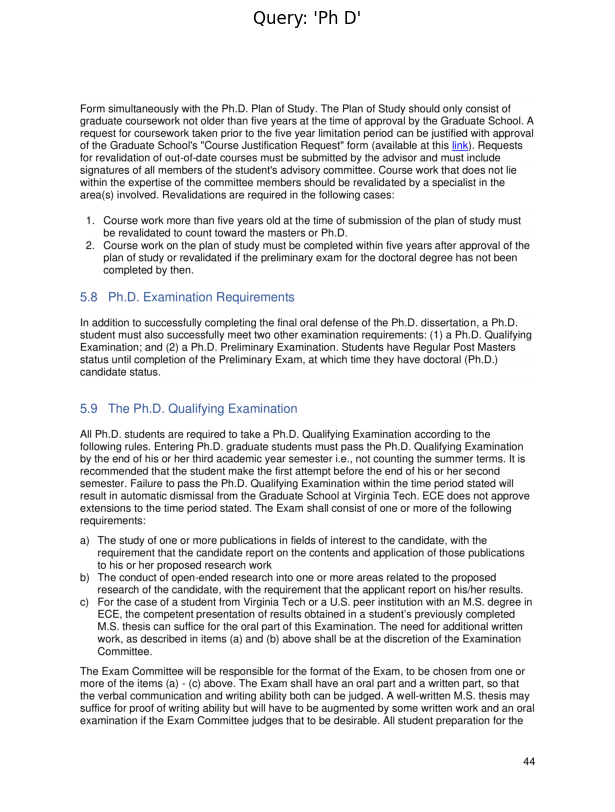

In [40]:
import fitz

#open pdf and load target

pdf_path = "ECE Graduate Policy Manual AY2023-2024.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(44) 

# get the image of the page
img = page.get_pixmap(dpi=300)

#save image
img.save("output_filename.png")
doc.close()

#convert the pixmap to a numpy array 
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h,img.w,img.n))

img_array

import matplotlib.pyplot as plt
plt.figure(figsize=(13,10))
plt.imshow(img_array)
plt.title(f"Query: '{query}'")
plt.axis("off")
plt.show()

### Dotproduct and cosine similarity examples


In [41]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

vector1 = torch.tensor([1,2,3], dtype=torch.float32)
vector2 = torch.tensor([1,2,3], dtype=torch.float32)
vector3 = torch.tensor([4,5,6], dtype=torch.float32)
vector4 = torch.tensor([-1,-2,-3], dtype=torch.float32)

print("dot product btw vector1 and vector 2:", dot_product(vector1,vector2))
print("dot product btw vector1 and vector 3:", dot_product(vector1,vector3))
print("dot product btw vector1 and vector 4:", dot_product(vector1,vector4))

#cosine similarity
print("cosine similarity btw v1 and v2:", cosine_similarity(vector1, vector2))
print("cosine similarity btw v1 and v3:", cosine_similarity(vector1, vector3))
print("cosine similarity btw v1 and v4:", cosine_similarity(vector1, vector4))

dot product btw vector1 and vector 2: tensor(14.)
dot product btw vector1 and vector 3: tensor(32.)
dot product btw vector1 and vector 4: tensor(-14.)
cosine similarity btw v1 and v2: tensor(1.0000)
cosine similarity btw v1 and v3: tensor(0.9746)
cosine similarity btw v1 and v4: tensor(-1.0000)


### functionizing semantic search pipeline

In [42]:
def retrieve_relevant_resources(query: str,
                                embeddings:torch.tensor,
                                model: SentenceTransformer = embedding_model,
                                n_resources_to_return: int=5,
                               print_time: bool=True):
    """
    embeds a query with model and returns top k scores and indices from embeddings.
    """

    #embed the query
    query_embedding = model.encode(query, convert_to_tensor=True)

    #get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_timer = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on ({len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores,indices = torch.topk(input=dot_scores,
                                k=n_resources_to_return)
    return scores, indices

def print_top_results_and_scores(query:str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    finds relevant passages given a query and print them out along with their scores.
    """
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    for score, idx in zip(scores,indices):
        print(f"Score: {score:.4f}")
        print("Text:")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        print(f"Page number: {pages_and_chunks[idx]['page_number']}")
        print("\n")                                           
    

In [43]:
query = "engineering student"
retrieve_relevant_resources(query="engineering", embeddings=embeddings)
print_top_results_and_scores(query=query, embeddings=embeddings)

[INFO] Time taken to get scores on (118 embeddings: -1.23704 seconds.
[INFO] Time taken to get scores on (118 embeddings: -1.25339 seconds.
Score: 0.6162
Text:
11 2 Admissions  2.1 Degrees Available  The Harry Lynde Bradley Department of
Electrical and Computer Engineering offers graduate degree programs leading to
the Master of Engineering (M.Eng.),Master of Science (M.S.), and Doctor of
Philosophy (Ph.D.) in Electrical Engineering (EE) and Computer Engineering
(CPE). The M.S. and Ph.D. degree programs are offered through the Blacksburg
campus as well as the extended campus consortia (National Capital Region,
Northern Virginia Center, Falls Church, Virginia; Central; Hampton Roads;
Western; Virtual; and VT-MENA through Alexandria and Cairo, Egypt).The
M.Eng.degree is offered at the National Capital Region (NCR) and Virtual
campuses. The ECE Department offers both an M.S., Thesis, and an M.S., Non-
Thesis, degree.For the M.S., Thesis, degree, each plan of study is developed by
the stud

### getting an LLM for local generation

In [44]:
import torch 
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes/(2**30))
print(f"available gpu memory: {gpu_memory_gb} gb")

available gpu memory: 8 gb


In [46]:
pip install -U "huggingface_hub[cli]"


Note: you may need to restart the kernel to use updated packages.


In [47]:
from huggingface_hub import notebook_login
notebook_login()

In [48]:
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 8 | Recommended model: Gemma 2B in 4-bit precision.
use_quantization_config set to: True
model_id set to: google/gemma-2b-it


### Loading an LLM locally
- Loading LLM locally with Huggingface transformers
- gemma-2b-it in 4 bit precision

1. A quantization config - config on what precision to load the model in (e.g. 8bit, 4bit, ..)
2. A model ID - tell transformers which model/tokenizer to load
3. a tokenizer - turns text into numbers ready for the llm(not same with embedding model)
4. An LLM model - use to generate textg based on an input

> **Note:** flash_attn -> hard to install on Windows..

In [49]:
import transformers
print(transformers.__version__)


4.48.0


### Solved the issue of meta tensors. Finished import of LLM. Will continue tomorrow. 

In [50]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. create a quantization config 
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit = True,
                                         bnb_4bit_compute_dtype = torch.float16,
                                        bnb_4bit_use_double_quant=True,
                                        bnb_4bit_quant_type='nf4')

if(is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
    attn_implementation = "flash_attention_2"
else:attn_implementation = "sdpa"
# 2. pick a model 
model_id= "google/gemma-2-2b-it"

# 3. instantiate tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path = model_id)

# 4. instantiate the model 
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16,
                                                 device_map='auto',
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=True,)
                                                 #attn_implementation=attn_implementation)
if not use_quantization_config:
    llm_model.to("cuda")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [51]:
# Gemma 2 locally imported successfully
llm_model

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear4bit(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2304, bias=False)
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear4bit(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (post_attention_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_

In [52]:
!nvidia-smi

Wed Jan 15 17:57:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.17                 Driver Version: 561.17         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   43C    P8              2W /   95W |    4040MiB /   8188MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [54]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

1602203904

In [60]:
def get_model_mem_size(model: torch.nn.Module):
    # get model parameters and buffer sizes
    mem_params = sum([param.nelement()* param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement()*buf.element_size() for buf in model.buffers()])

    model_mem_bytes = mem_params + mem_buffers
    model_mem_mb = model_mem_bytes / (1024**2)
    model_mem_gb = model_mem_bytes / (1024**3)

    return {"model_mem_bytes" : round(model_mem_bytes),
            "model_mem_mb" : round(model_mem_mb),
            "model_mem_Gb" : round(model_mem_gb,2)}
get_model_mem_size(llm_model)

{'model_mem_bytes': 2192270336, 'model_mem_mb': 2091, 'model_mem_Gb': 2.04}

### Generating text with local LLM
- check chat template to see how the model has been tuned previously. 

In [64]:
input_text = "what are policies for a master's student"
print(f"Input text:\n{input_text}")

# create prompt template for instruction tuned model(gemma-2-2b-it)
dialogue_template = [
    {"role":"user",
     "content":input_text}
     ]

prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False,
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted): \n{prompt}")

Input text:
what are policies for a master's student

Prompt (formatted): 
<bos><start_of_turn>user
what are policies for a master's student<end_of_turn>
<start_of_turn>model



In [65]:
tokenizer

GemmaTokenizerFast(name_or_path='google/gemma-2-2b-it', vocab_size=256000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<start_of_turn>', '<end_of_turn>']}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	5: AddedToken("<2mass>", rstrip=False, lstrip=False, single_w

In [68]:
%%time 

#tokenize the input text(turn into number and send to gpu)
input_ids = tokenizer(prompt,
                      return_tensors="pt").to("cuda")
input_ids

#generate output from local llm
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256)
print(f"Model output(tokens):\n{outputs[0]}\n")

The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


Model output(tokens):
tensor([     2,      2,    106,   1645,    108,   5049,    708,  12003,    604,
           476,   7443, 235303, 235256,   5913,    107,    108,    106,   2516,
           108,   1718, 235303, 235256,   1775,    692, 235303,    478,   7166,
          1105,  12003, 235341,    139,  13595, 235303, 235256,   5913,  12003,
           798,    614,   4756,   7209, 235269,    712,   2142, 235303, 235256,
          3376,    665,   1706,   1280,   1009,   2621,   4516, 235265, 235248,
           109,    688,  41233,  46040,    688,    109, 235287,   5231,  41233,
         75585,  66058,    139,   1596,    603,  20305, 235341,  54159,    861,
         13435, 235303, 235256,  12003,    611, 154739, 235269,  57473, 235269,
           578,  15459,  70601, 235265,    139,    108, 235287,   5231,  27844,
           578,  64298,  66058,    139,   4417,    861,   2733, 235303, 235256,
         18307,    604,  25532,    696,   8250, 235269,  68253, 235269,    578,
         11859,  1

In [69]:
# decode output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output(decoded):\n{outputs_decoded}\n")

Model output(decoded):
<bos><bos><start_of_turn>user
what are policies for a master's student<end_of_turn>
<start_of_turn>model
It's great you're thinking about policies!  Master's student policies can be quite broad, so let's break it down into some key areas. 

**Academic Policies**

* **Academic Integrity:**  This is crucial! Understand your university's policies on plagiarism, cheating, and academic misconduct.  
* **Attendance and Participation:**  Check your program's expectations for attendance at classes, seminars, and lab sessions. Some programs may have specific requirements for participation in group work.
* **Grading Policies:**  Know how grades are calculated, what constitutes a passing grade, and the process for appeals.
* **Deadlines and Extensions:**  Be aware of deadlines for assignments, exams, and research proposals. Understand the university's policy on extensions and how to request them.
* **Academic Support:**  Familiarize yourself with the resources available to 

### Augmenting prompt with context items(prompt engineering)
1. clear instructions
2. examples of input/output
3. room to think


In [73]:
query_list = [
    "What grades should I get to graduate?",
    "What are fundings available for master's student?",
    "What are the required courses for Software & Machine Intelligence track?",
    "Can a master's student change to PhD track?"]

In [85]:
def prompt_formatter(query:str,
                     context_items:list[dict]) -> str:
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])
    base_prompt = """Please answer the query based on the following context items.
Do a step-by-step thinking before answering the query.
Only return the answer.
Make sure your answers are as explanatory as possible.
\n{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    base_prompt = base_prompt.format(context=context, query=query)


    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)

    return prompt

In [93]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
    
# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: What grades should I get to graduate?
[INFO] Time taken to get scores on (118 embeddings: -3999.32193 seconds.
<bos><start_of_turn>user
Please answer the query based on the following context items.
Do a step-by-step thinking before answering the query.
Only return the answer.
Make sure your answers are as explanatory as possible.

- 17 2.9.5 Master of Engineering (M.Eng.),Project and Report To be considered for the M.Eng.degree program, students should meet the following admission standards.Students holding or expecting a bachelor’s degree from an ABET accredited engineering school should have a minimum GPA of 3.0 for the last 60 course credit hours (approximately last 2 years), as it appears on the transcript.For students from non-ABET programs, the minimum GPA is 3.5 or above, depending on the program.Additional restrictions may apply based on available funding, space within the program, compatibility with program objectives, or faculty advising.  If circumstances warrant an e

In [97]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.5, #adjusted to 0.5
                             do_sample=True, 
                             max_new_tokens=256) 

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: What grades should I get to graduate?
RAG answer:
<bos>The provided text outlines specific GPA requirements for admission and course completion for both the Master of Engineering (M.Eng.) and Master of Science (M.S.) programs at Virginia Tech. 

Here's a breakdown:

**M.Eng. Program:**

* **Minimum GPA:** 3.0 for the last 60 course credit hours.
* **Exceptions:**  There may be exceptions based on:
    * Available funding
    * Space within the program
    * Compatibility with program objectives
    * Faculty advising
    * Specific circumstances

**M.S. Thesis (Thesis-based):**

* **Minimum GPA:** 3.3 for the last 60 course credit hours.
* **Thesis Students:**  Must maintain a minimum 3.0 GPA on the plan of study and overall transcript.
* **Pass/Fail Courses:**  Not permitted on the plan of study.
* **Thesis Requirement:**  Must complete a minimum of 9-12 credit hours under the Commonwealth Campus Program before applying for regular admission.

**M.S. Non-Thesis (Non-Thesis-base

In [98]:
def ask(query, 
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True, 
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)
    
    context_items = [pages_and_chunks[i] for i in indices]

    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU 
        
    prompt = prompt_formatter(query=query,
                              context_items=context_items)
    
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)
    
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    if return_answer_only:
        return output_text
    
    return output_text, context_items

In [99]:
query = random.choice(query_list)
print(f"Query: {query}")
answer, context_items = ask(query=query, 
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: What are the required courses for Software & Machine Intelligence track?
[INFO] Time taken to get scores on (118 embeddings: -4218.57848 seconds.
Answer:

The provided text doesn't list specific required courses for the Software &
Machine Intelligence track. However, it does mention the following:    *
**Courses from the ECE or CS departments:** ECE/CS courses are required. *
**Specific ECE/CS courses:**  The context mentions specific ECE and CS courses
as part of the Master of Science (M.S.), Non-Thesis, in EE requirements.    Let
me know if you need further clarification.  <end_of_turn>
Context items:


[{'page_number': 20,
  'sentence_chunk': '24 Undergraduate Course Co-Located or Conjoined Graduate Course ECE 4104, Microwave & RF ECE 5104G, Adv Microwave & RF ECE 4134, Fiber Optics & App ECE 5134G, Adv Fiber Optics & App ECE 4154, Space Weather ECE 5164, Intro to Space Science I ECE 4194, Remote Sensing ECE 5194, Remote Sensing ECE 4364, Alternate Energy Systems ECE 5374G, Adv Alternate Energy Systems ECE 4414, Linux Kernel Programming ECE 5414, Adv Linux Kernel Programming ECE 4424, Machine Learning ECE 5424, Adv.Machine Learning ECE 4444, Technological Singularity ECE 5444, Adv Technological Singularity ECE 4540, VLSI Circuit Design ECE 5545, Adv.VLSI Design ECE 4550, Real-Time Systems ECE 5550G, Adv.Real-Time Systems ECE 4554, Computer Vision ECE 5554, Computer Vision  3.5.4 Electrical Engineering Area Courses The areas of electrical engineering courses are determined by the course numbering scheme given in the following table.Only courses at or above the 4000-level may be listed